In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as u
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet, CharmmPsfFile
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import seaborn as sbn

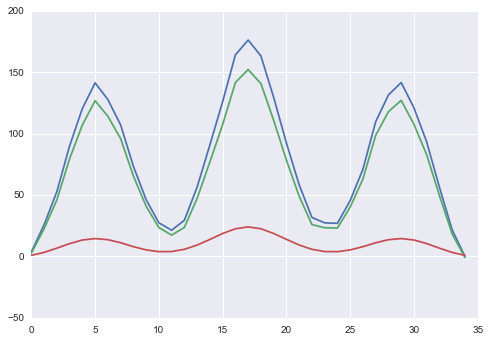

In [2]:
param = CharmmParameterSet('../../data/charmm_ff/top_all36_cgenff.rtf',
                           '../../data/charmm_ff/par_all36_cgenff.prm')
structure = '../structure/butane.psf'
scan = '../torsion_scans/DFT_b3lyp/butane_scan_b3lyp_360.log'

butane_scan = ScanSet.parse_psi4(scan, structure)
butane_scan.compute_energy(param)

plt.plot(butane_scan.mm_energy)
plt.plot(butane_scan.delta_energy)
plt.plot(butane_scan.qm_energy)

In [3]:
# Create model (code is modified to set up qm_fit to this difference potential)
# Model and sample. The code was modified to fit the difference potential. 

platform = mm.Platform.getPlatformByName('Reference')

model = Model.TorsionFitModelEliminatePhase(param, butane_scan, platform=platform, decouple_n=True,
                                            param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')])

sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='diff_pot_mult_off.db', verbose=5)

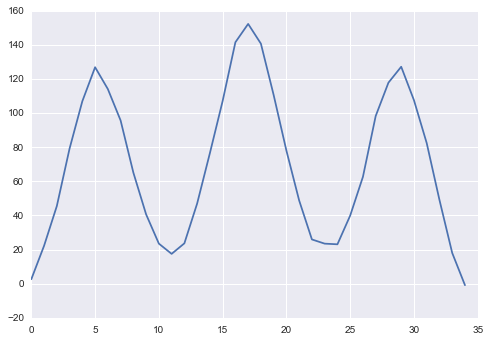

In [4]:
plt.plot(sampler.qm_fit.value)

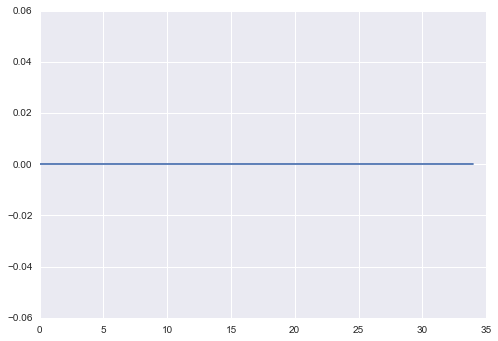

In [5]:
# Turn off all parameters

# Turn everything off
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0
param.dihedral_types[('HGA3', 'CG331', 'CG321', 'HGA2')][0].phi_k=0
param.dihedral_types[('HGA2', 'CG321', 'CG331', 'HGA3')][0].phi_k=0
param.dihedral_types[('HGA3', 'CG331', 'CG321', 'CG321')][0].phi_k=0
param.dihedral_types[('CG321', 'CG321', 'CG331', 'HGA3')][0].phi_k=0
param.dihedral_types[('HGA2', 'CG321', 'CG321', 'HGA2')][0].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'HGA2')][0].phi_k=0
param.bond_types[('CG331', 'CG321')].k=0
param.bond_types[('CG321', 'CG321')].k=0
param.bond_types[('CG331', 'HGA3')].k=0
param.bond_types[('CG321', 'HGA2')].k=0
param.urey_bradley_types[('CG331', 'CG321', 'CG321')].k  = 0
param.urey_bradley_types[('CG331', 'CG321', 'HGA2')].k = 0
param.urey_bradley_types[('CG321', 'CG321', 'HGA2')].k = 0
param.urey_bradley_types[('HGA3', 'CG331', 'CG321')].k = 0
param.urey_bradley_types[('HGA3', 'CG331', 'HGA3')].k = 0
param.urey_bradley_types[('HGA2', 'CG321', 'HGA2')].k = 0

param.angle_types[('CG331', 'CG321', 'CG321')].k  = 0
param.angle_types[('CG331', 'CG321', 'HGA2')].k = 0
param.angle_types[('CG321', 'CG321', 'HGA2')].k = 0
param.angle_types[('HGA3', 'CG331', 'CG321')].k = 0
param.angle_types[('HGA3', 'CG331', 'HGA3')].k = 0
param.angle_types[('HGA2', 'CG321', 'HGA2')].k = 0

# Turn off LJ
param.atom_types['CG331'].sigma_14 = 1.0
param.atom_types['CG331'].rmin = 1.0
param.atom_types['CG331'].rmin_14 = 1.0
param.atom_types['CG331'].epsilon_14 = 0
param.atom_types['CG331'].sigma=1.0
param.atom_types['CG331'].epsilon = 0.0
param.atom_types['CG321'].epsilon_14 = 0.0
param.atom_types['CG321'].rmin_14 = 1.0
param.atom_types['CG321'].sigma_14 = 1.0
param.atom_types['CG321'].sigma=1.0
param.atom_types['CG321'].epsilon = 0.0
param.atom_types['HGA3'].epsilon_14 = 0.0
param.atom_types['HGA3'].sigma = 1.0
param.atom_types['HGA3'].epsilon = 0.0
param.atom_types['HGA2'].epsilon_14 = 0.0
param.atom_types['HGA2'].sigma = 1.0
param.atom_types['HGA2'].epsilon = 0.0

# Turn off charge

for atom in butane_scan.structure.atoms:
    atom.charge = 0
    
# Reparameterize 
butane_scan.integrator = mm.VerletIntegrator(0.004*u.picoseconds)
butane_scan.create_context(param)
butane_scan.compute_energy(param)
plt.plot(butane_scan.mm_energy)

In [6]:
sampler.sample(10000)

Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method Metropolis to stochastic log_sigma
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
 [-----------------100%-----------------] 10000 of 10000 complete in 1799.0 sec

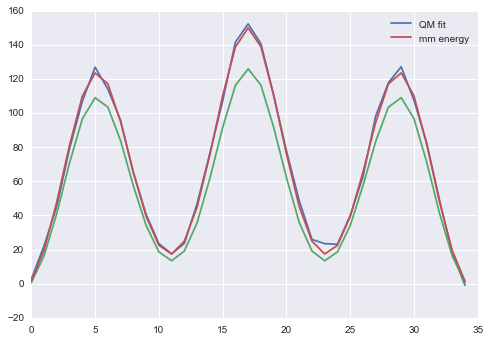

In [7]:
plt.plot(sampler.qm_fit.value, label='QM fit')
plt.plot(butane_scan.delta_energy)
plt.plot(butane_scan.mm_energy, label='mm energy')
plt.legend()

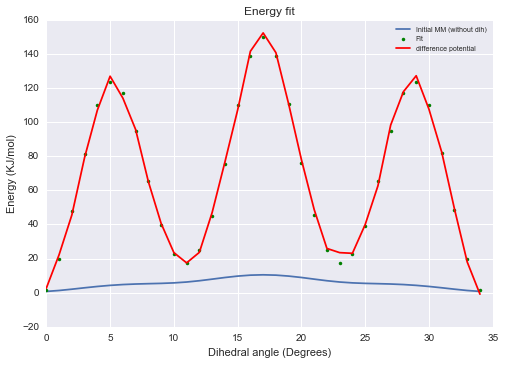

In [8]:
plt.plot(sampler.trace('mm_energy')[0], label='Initial MM (without dih)')
plt.plot(sampler.trace('mm_energy')[-1], '.', color='green', label='Fit')
plt.plot(sampler.qm_fit.value, color='red', label='difference potential')
plt.legend(prop={'size': 7})
plt.title('Energy fit')
plt.xlabel('Dihedral angle (Degrees)')
plt.ylabel('Energy (KJ/mol)')
#plt.savefig('Energy_fit_no_mult.pdf')

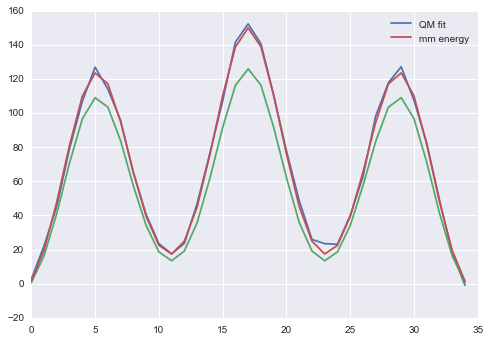

In [9]:
plt.plot(sampler.qm_fit.value, label='QM fit')
plt.plot(butane_scan.delta_energy)
plt.plot(butane_scan.mm_energy, label='mm energy')
plt.legend()

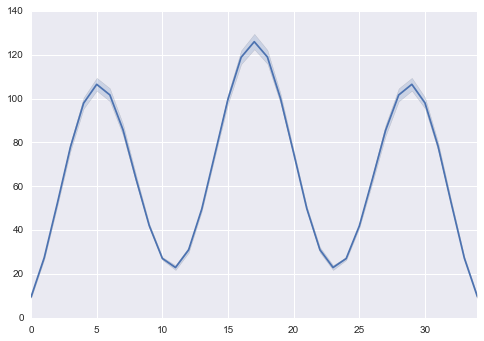

In [10]:
sbn.tsplot(sampler.trace('mm_energy')[:100])

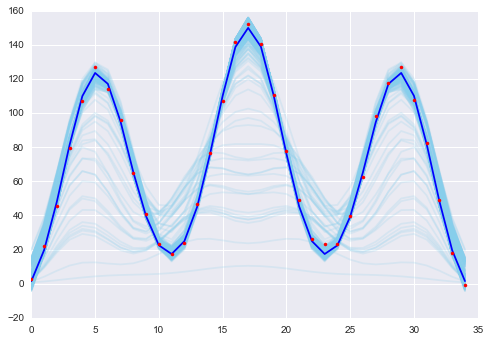

In [11]:
for i in range(1000):
    plt.plot(sampler.trace('mm_energy')[i], alpha=0.2, color='skyblue')
plt.plot(sampler.trace('mm_energy')[-1], color='Blue')
plt.plot(sampler.qm_fit.value, 'r.', label='Diff potential')


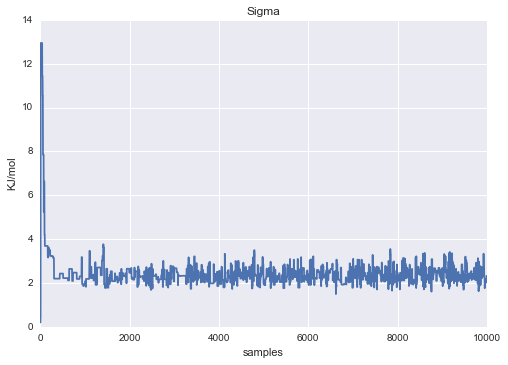

In [14]:
plt.plot(np.exp(sampler.trace('log_sigma')[:]), label='sigma')
plt.xlabel('samples')
plt.ylabel('KJ/mol')
plt.title('Sigma')
plt.savefig('sigma_mult_off_diff.pdf')

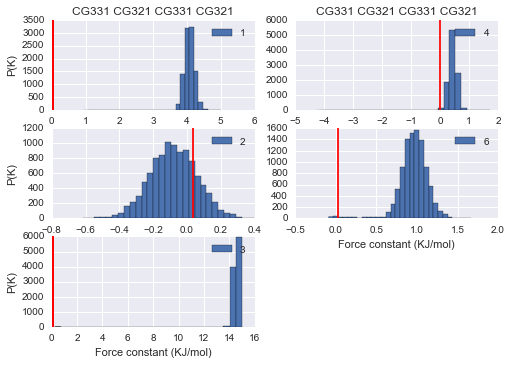

In [13]:
plt.title("CG331 CG321 CG331 CG321")

plt.subplot(3, 2, 1)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[:], bins=30, label='1')
plt.axvline(0, color='r', linewidth=3)
plt.legend()
plt.ylabel('P(K)')
plt.title("CG331 CG321 CG331 CG321")

plt.subplot(3, 2, 3)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[:], bins=30, label='2')
plt.axvline(0.038, color='r')
plt.legend()
plt.ylabel('P(K)')

plt.subplot(3, 2, 5)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[:], bins=30, label='3')
plt.axvline(0, color='r', linewidth=3)
plt.legend()
plt.ylabel('P(K)')
plt.xlabel('Force constant (KJ/mol)')

plt.subplot(3, 2, 2)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[:], bins=30, label='4')
plt.title("CG331 CG321 CG331 CG321")
plt.axvline(0, color='r')
plt.legend()

plt.subplot(3, 2, 4)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[:], bins=30, label='6')
plt.axvline(0.032, color='r')
plt.legend()
plt.xlabel('Force constant (KJ/mol)')

plt.savefig('parameter_hist_mult_off_diff.pdf')